In [1]:
!unzip /content/archive.zip -d /content/data


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data/cloudy/train_23566.jpg  
  inflating: /content/data/data/cloudy/train_23598.jpg  
  inflating: /content/data/data/cloudy/train_23608.jpg  
  inflating: /content/data/data/cloudy/train_23634.jpg  
  inflating: /content/data/data/cloudy/train_23636.jpg  
  inflating: /content/data/data/cloudy/train_23646.jpg  
  inflating: /content/data/data/cloudy/train_2366.jpg  
  inflating: /content/data/data/cloudy/train_23664.jpg  
  inflating: /content/data/data/cloudy/train_23706.jpg  
  inflating: /content/data/data/cloudy/train_2380.jpg  
  inflating: /content/data/data/cloudy/train_23805.jpg  
  inflating: /content/data/data/cloudy/train_23806.jpg  
  inflating: /content/data/data/cloudy/train_23826.jpg  
  inflating: /content/data/data/cloudy/train_23843.jpg  
  inflating: /content/data/data/cloudy/train_23877.jpg  
  inflating: /content/data/data/cloudy/train_23884.jpg  
  inflating: /content/data/data/cloudy/

In [2]:
%pip install numpy pandas matplotlib seaborn tensorflow scikit-learn

In [3]:
import numpy as np
import pandas as pd
import io
import os
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

## Explore Data

In [4]:
data_dir = '/content/data/data'
labels = os.listdir(data_dir)
labels

['desert', 'green_area', 'water', 'cloudy']

Found 5631 images belonging to 4 classes.


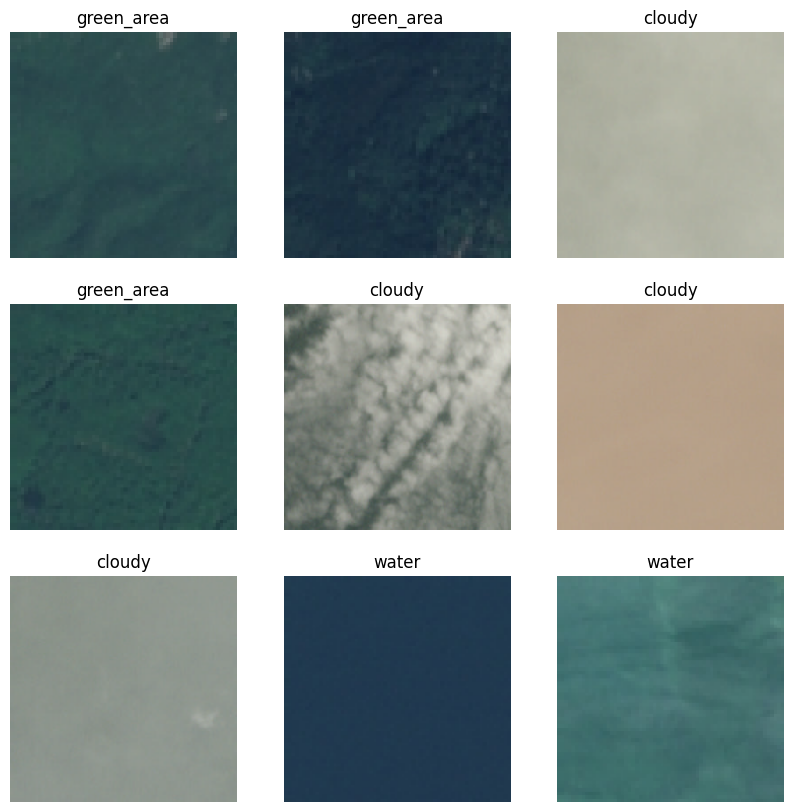

In [6]:

# Define image size and batch size
image_size = (224, 224)
batch_size = 32
# Use ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load the dataset with appropriate labeling
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)
# Retrieve class names
class_names = list(train_generator.class_indices.keys())
# Visualize a few samples from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis('off')
    break  # Only display one batch of images
plt.show()


In [7]:
img_width, img_height = 224, 224
target_size = (img_width,img_height)
batch_size = 32

In [8]:
#Create a data generator for image augmentation
datagen = ImageDataGenerator( samplewise_center=True,  
                             rotation_range=10,  
                             zoom_range = 0.1, 
                             width_shift_range=0.1,  
                             height_shift_range=0.1,  
                             horizontal_flip=True,  
                             vertical_flip=False,
                             rescale=1./255,
                             validation_split=0.2) #split data, 80% for training and 20% for testing


#create training set from folders
train_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       shuffle=True,subset='training')

#create test set
test_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                      class_mode='categorical',
                                       shuffle=False,subset='validation')

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


## Evaluation Functions

In [9]:
def learning_curves(history):
    #plot the result
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot
    plt.plot(epochs, acc, color='green', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()
    #loss plot
    plt.plot(epochs, loss, color='pink', label='Training Loss')
    plt.plot(epochs, val_loss, color='red', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [10]:
def get_predections(model):
    # Generate predictions on the test set
    y_pred = model.predict(test_data)

    # Compute the confusion matrix
    y_true = test_data.classes
    y_pred = tf.argmax(y_pred, axis=1)
    return y_true,y_pred

def show_confusion_matrix(y_true,y_pred):
    cm  = confusion_matrix(y_pred,y_true)
    df_cm = pd.DataFrame(cm, index =   ["cloud","desert" ,'green_area', 'water'],
                  columns = ["cloud","desert" ,'green_area', 'water'])

    seaborn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
    plt.title('confusion matrix')
    plt.ylabel('prediction')
    plt.xlabel('Actual')
    plt.show()

def print_classification_report(y_true,y_pred):
    target_names = ["cloud","desert" ,'green_area', 'water']
    print(classification_report(y_true, y_pred, target_names=target_names))

## VGG19 based model

In [11]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg_base_model =  VGG19(include_top=True , weights='imagenet')
for layer in vgg_base_model.layers:
    layer.trainable= False

574710816/574710816 [==============================] - 14s 0us/step


Load the vgg19 model from keras

In [12]:
vgg_base_model = tf.keras.Model(inputs=vgg_base_model.input, outputs=vgg_base_model.layers[-2].output)
vgg_model = tf.keras.Sequential()
for layer in vgg_base_model.layers:
    vgg_model.add(layer)

vgg_model.add(tf.keras.layers.Dense(4, activation='softmax'))

copy vgg layers and add top layer

In [13]:
vgg_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)


In [14]:
vgg_history = vgg_model.fit(train_data,
    validation_data = test_data,
    callbacks = [early],
    epochs = 15)

Epoch 1/15
141/141 [==============================] - 95s 601ms/step - loss: 1.2579 - accuracy: 0.4253 - val_loss: 1.1364 - val_accuracy: 0.4734
Epoch 2/15
141/141 [==============================] - 77s 549ms/step - loss: 0.9970 - accuracy: 0.6142 - val_loss: 0.9155 - val_accuracy: 0.7025
Epoch 3/15
141/141 [==============================] - 77s 545ms/step - loss: 0.8095 - accuracy: 0.7536 - val_loss: 0.7531 - val_accuracy: 0.7771
Epoch 4/15
141/141 [==============================] - 82s 578ms/step - loss: 0.6875 - accuracy: 0.8264 - val_loss: 0.7177 - val_accuracy: 0.7247
Epoch 5/15
141/141 [==============================] - 90s 640ms/step - loss: 0.6145 - accuracy: 0.8537 - val_loss: 0.5878 - val_accuracy: 0.8179
Epoch 6/15
141/141 [==============================] - 76s 540ms/step - loss: 0.5546 - accuracy: 0.8626 - val_loss: 0.5532 - val_accuracy: 0.8393
Epoch 7/15
141/141 [==============================] - 84s 596ms/step - loss: 0.5091 - accuracy: 0.8717 - val_loss: 0.5095 - val_ac

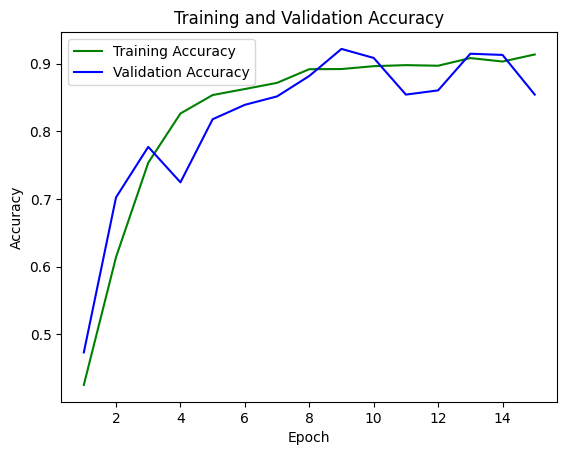

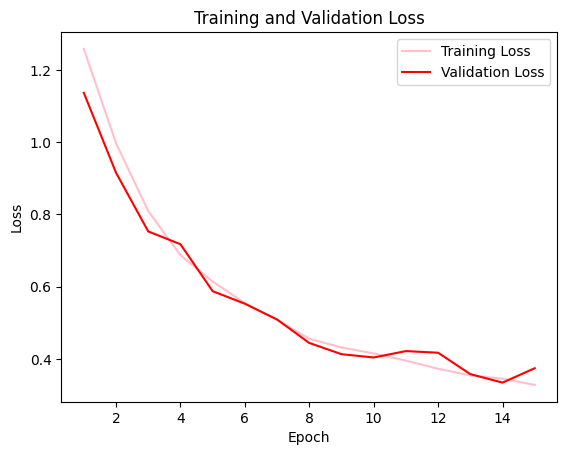

In [15]:
learning_curves(vgg_history)

In [16]:
vgg_model.evaluate(test_data)

36/36 [==============================] - 15s 414ms/step - loss: 0.3743 - accuracy: 0.8588


[0.3743399977684021, 0.8587921857833862]

## MobileNet

### 1 layer

In [17]:
mobile_base_model = tf.keras.applications.MobileNet()
for layer in mobile_base_model.layers:
    layer.trainable= False

17225924/17225924 [==============================] - 1s 0us/step


### 3 layers

In [18]:
mobile_base_model = tf.keras.applications.MobileNet()
for layer in mobile_base_model.layers[:-3]:
    layer.trainable= False

### 5 layers

In [19]:
mobile_base_model = tf.keras.applications.MobileNet()
for layer in mobile_base_model.layers[:-5]:
    layer.trainable= False

#### model build

In [20]:
mobile_base_model = tf.keras.Model(inputs=mobile_base_model.input, outputs=mobile_base_model.layers[-2].output)

mobile_model = tf.keras.Sequential()

for layer in mobile_base_model.layers:
    mobile_model.add(layer)

mobile_model.add(tf.keras.layers.Dense(4, activation='softmax'))

#### Adam optimizer

In [21]:
mobile_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [22]:
mobile_history = mobile_model.fit(train_data,
    validation_data = test_data,
#     callbacks = [early],
    epochs = 15)

Epoch 1/15
141/141 [==============================] - 75s 496ms/step - loss: 0.1533 - accuracy: 0.9556 - val_loss: 0.0970 - val_accuracy: 0.9760
Epoch 2/15
141/141 [==============================] - 69s 488ms/step - loss: 0.0659 - accuracy: 0.9811 - val_loss: 0.1883 - val_accuracy: 0.9591
Epoch 3/15
141/141 [==============================] - 68s 484ms/step - loss: 0.0513 - accuracy: 0.9853 - val_loss: 0.0580 - val_accuracy: 0.9813
Epoch 4/15
141/141 [==============================] - 69s 489ms/step - loss: 0.0353 - accuracy: 0.9896 - val_loss: 0.0297 - val_accuracy: 0.9902
Epoch 5/15
141/141 [==============================] - 68s 480ms/step - loss: 0.0277 - accuracy: 0.9911 - val_loss: 0.0499 - val_accuracy: 0.9893
Epoch 6/15
141/141 [==============================] - 69s 487ms/step - loss: 0.0395 - accuracy: 0.9907 - val_loss: 0.0321 - val_accuracy: 0.9902
Epoch 7/15
141/141 [==============================] - 68s 482ms/step - loss: 0.0230 - accuracy: 0.9916 - val_loss: 0.0401 - val_ac

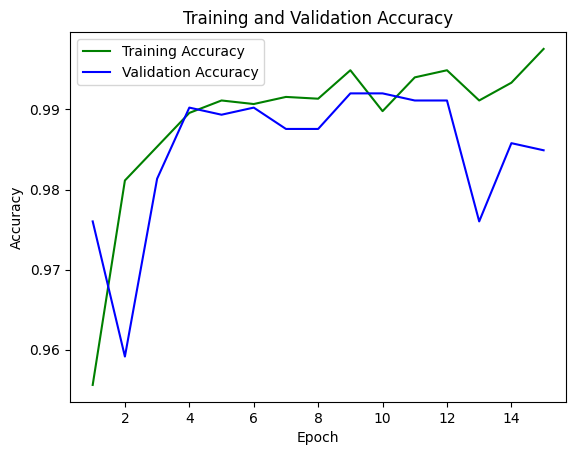

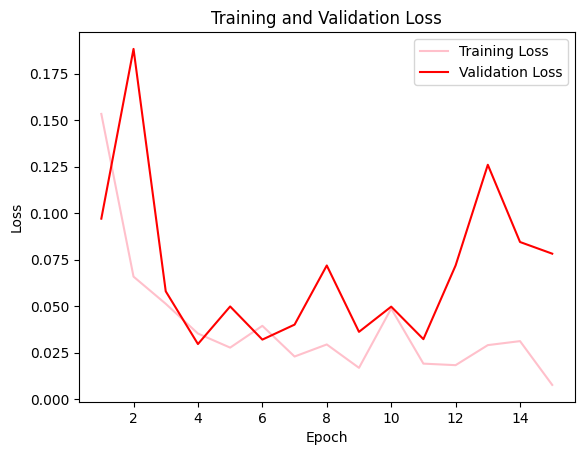

In [23]:
learning_curves(mobile_history)

In [24]:
mobile_model.evaluate(test_data)

36/36 [==============================] - 14s 385ms/step - loss: 0.0464 - accuracy: 0.9911


[0.0464467778801918, 0.9911190271377563]

36/36 [==============================] - 22s 606ms/step


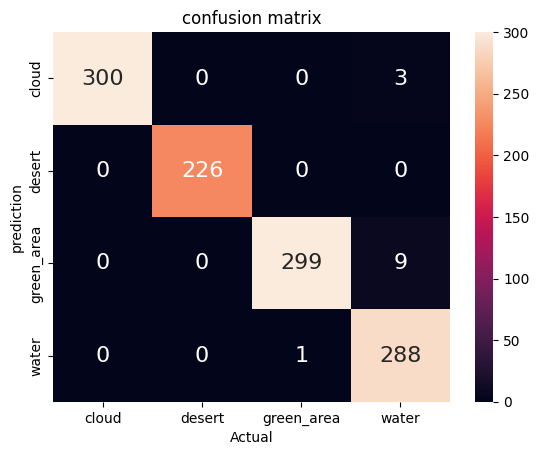

In [25]:
y_true,y_pred = get_predections(mobile_model)
show_confusion_matrix(y_true,y_pred)

In [26]:
print_classification_report(y_true,y_pred)

              precision    recall  f1-score   support

       cloud       0.99      1.00      1.00       300
      desert       1.00      1.00      1.00       226
  green_area       0.97      1.00      0.98       300
       water       1.00      0.96      0.98       300

    accuracy                           0.99      1126
   macro avg       0.99      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126



#### SGD optimizer

In [27]:
mobile_model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [28]:
mobile_history = mobile_model.fit(train_data,
    validation_data = test_data,
#     callbacks = [early],
    epochs = 15)

Epoch 1/15
141/141 [==============================] - 77s 529ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0538 - val_accuracy: 0.9911
Epoch 2/15
141/141 [==============================] - 85s 602ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.0479 - val_accuracy: 0.9911
Epoch 3/15
141/141 [==============================] - 69s 488ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0642 - val_accuracy: 0.9920
Epoch 4/15
141/141 [==============================] - 69s 492ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.0482 - val_accuracy: 0.9911
Epoch 5/15
141/141 [==============================] - 71s 506ms/step - loss: 0.0055 - accuracy: 0.9973 - val_loss: 0.0365 - val_accuracy: 0.9929
Epoch 6/15
141/141 [==============================] - 69s 488ms/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.0483 - val_accuracy: 0.9885
Epoch 7/15
141/141 [==============================] - 70s 496ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0548 - val_ac

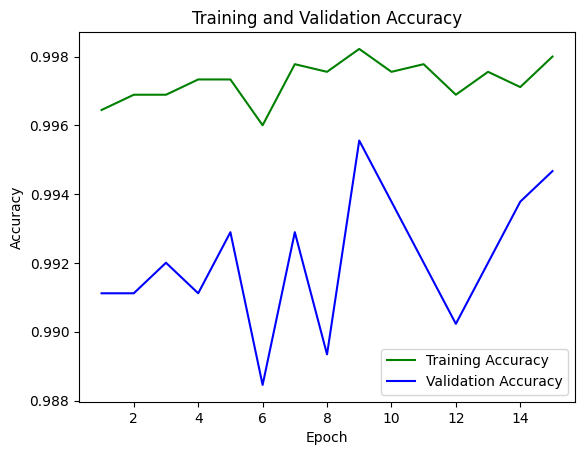

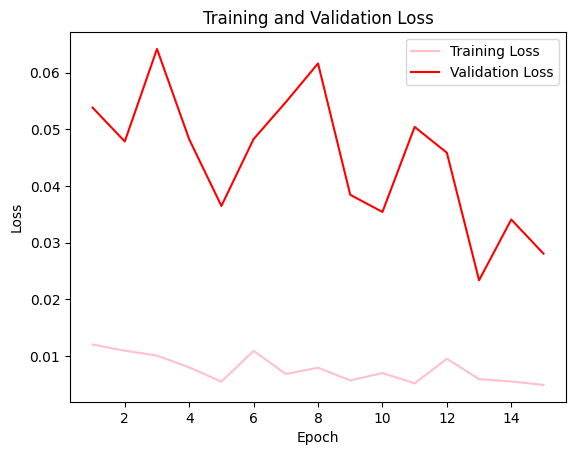

In [29]:
learning_curves(mobile_history)

In [30]:
mobile_model.evaluate(test_data)

36/36 [==============================] - 29s 803ms/step - loss: 0.0376 - accuracy: 0.9929


[0.03757767379283905, 0.9928951859474182]

36/36 [==============================] - 25s 681ms/step


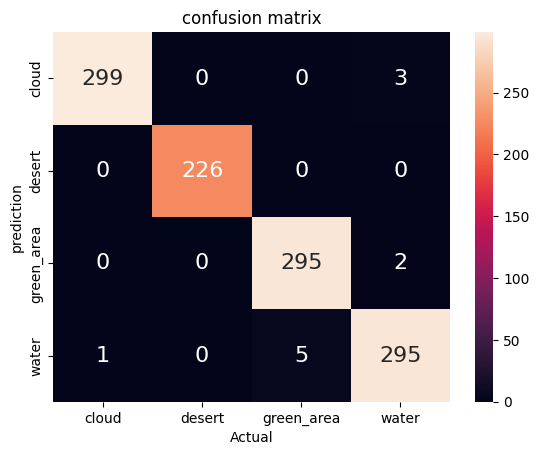

In [31]:
y_true,y_pred = get_predections(mobile_model)
show_confusion_matrix(y_true,y_pred)

In [32]:
print_classification_report(y_true,y_pred)

              precision    recall  f1-score   support

       cloud       0.99      1.00      0.99       300
      desert       1.00      1.00      1.00       226
  green_area       0.99      0.98      0.99       300
       water       0.98      0.98      0.98       300

    accuracy                           0.99      1126
   macro avg       0.99      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126



## ResNet

In [46]:
from tensorflow.keras.applications.resnet50 import preprocess_input
target_size = (244, 244)
#Create a data generator for image augmentation
datagen = ImageDataGenerator( preprocessing_function=preprocess_input,
                             samplewise_center=True,  
                             rotation_range=10,  
                             zoom_range = 0.1, 
                             width_shift_range=0.1,  
                             height_shift_range=0.1,  
                             horizontal_flip=True,  
                             vertical_flip=False,
                             rescale=1./255,
                             validation_split=0.2) 
#create training set from folders
train_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       shuffle=True,subset='training')

#create test set
test_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                      class_mode='categorical',
                                       shuffle=False,subset='validation')

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


In [34]:
from tensorflow.keras.applications import ResNet50

resnet_base_model = ResNet50(weights='imagenet', include_top=True)

for layer in resnet_base_model.layers:
    layer.trainable = False

102967424/102967424 [==============================] - 3s 0us/step


In [35]:
x = resnet_base_model(resnet_base_model.input)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

resnet_model = tf.keras.Model(inputs=resnet_base_model.input, outputs=outputs)

In [36]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [37]:
resnet_history = resnet_model.fit(train_data,
    validation_data = test_data,
    callbacks = [early],
    epochs = 15)

Epoch 1/15
141/141 [==============================] - 85s 555ms/step - loss: 1.3834 - accuracy: 0.2528 - val_loss: 1.3811 - val_accuracy: 0.2664
Epoch 2/15
141/141 [==============================] - 78s 553ms/step - loss: 1.3805 - accuracy: 0.2622 - val_loss: 1.3797 - val_accuracy: 0.2664
Epoch 3/15
141/141 [==============================] - 77s 549ms/step - loss: 1.3799 - accuracy: 0.2553 - val_loss: 1.3796 - val_accuracy: 0.2664
Epoch 4/15
141/141 [==============================] - 76s 539ms/step - loss: 1.3798 - accuracy: 0.2628 - val_loss: 1.3795 - val_accuracy: 0.2567
Epoch 5/15
141/141 [==============================] - 76s 542ms/step - loss: 1.3798 - accuracy: 0.2666 - val_loss: 1.3795 - val_accuracy: 0.2664
Epoch 6/15
141/141 [==============================] - 79s 560ms/step - loss: 1.3798 - accuracy: 0.2615 - val_loss: 1.3795 - val_accuracy: 0.2664
Epoch 7/15
141/141 [==============================] - 77s 543ms/step - loss: 1.3797 - accuracy: 0.2659 - val_loss: 1.3795 - val_ac

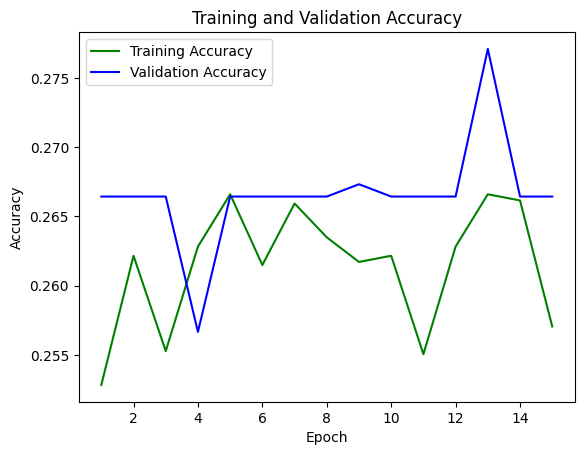

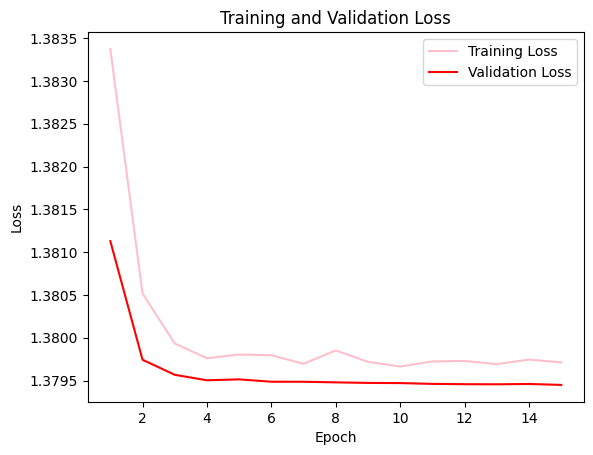

In [38]:
learning_curves(resnet_history)

In [39]:
resnet_model.evaluate(test_data)

36/36 [==============================] - 15s 426ms/step - loss: 1.3794 - accuracy: 0.2664


[1.3794490098953247, 0.2664298415184021]

## Traditional Model

In [47]:

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(244, 244, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [48]:
# Train the model
history = model.fit(
      train_data,
      validation_data = test_data,
      epochs=15)

Epoch 1/15
141/141 [==============================] - 90s 604ms/step - loss: 0.5751 - accuracy: 0.6646 - val_loss: 0.5028 - val_accuracy: 0.6856
Epoch 2/15
141/141 [==============================] - 88s 628ms/step - loss: 0.4729 - accuracy: 0.7250 - val_loss: 0.4342 - val_accuracy: 0.7647
Epoch 3/15
141/141 [==============================] - 86s 610ms/step - loss: 0.4532 - accuracy: 0.7676 - val_loss: 0.4082 - val_accuracy: 0.8091
Epoch 4/15
141/141 [==============================] - 84s 594ms/step - loss: 0.3773 - accuracy: 0.8368 - val_loss: 0.4868 - val_accuracy: 0.7504
Epoch 5/15
141/141 [==============================] - 87s 618ms/step - loss: 0.3799 - accuracy: 0.8382 - val_loss: 0.4098 - val_accuracy: 0.8215
Epoch 6/15
141/141 [==============================] - 84s 597ms/step - loss: 0.3590 - accuracy: 0.8493 - val_loss: 0.4091 - val_accuracy: 0.7851
Epoch 7/15
141/141 [==============================] - 85s 603ms/step - loss: 0.3508 - accuracy: 0.8537 - val_loss: 0.3618 - val_ac

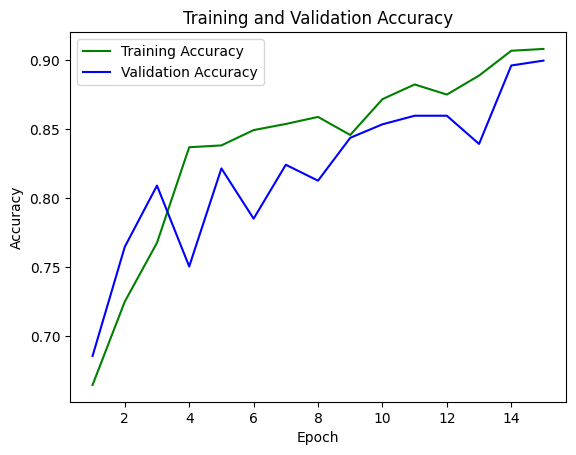

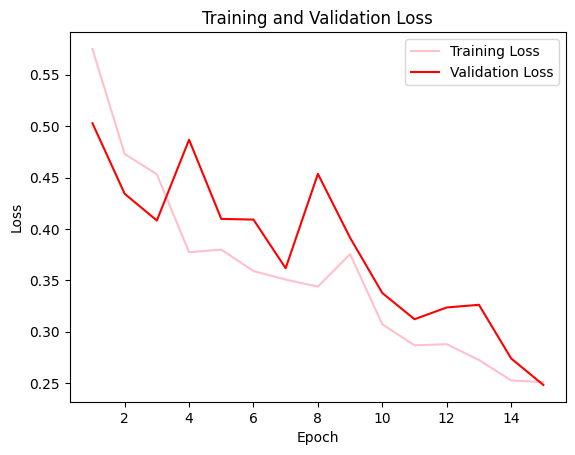

In [49]:
learning_curves(history)

In [50]:
model.evaluate(test_data, steps=50)

36/50 [====================>.........] - ETA: 6s - loss: 0.2435 - accuracy: 0.9023

50/50 [==============================] - 17s 341ms/step - loss: 0.2435 - accuracy: 0.9023


[0.2434503734111786, 0.9023090600967407]